# QML-HEP GSoC 2024 Tasks

## Task VI: Quantum representation learning
In this task you should implement a simple representation learning scheme based on a contrastive loss:
- Load the MNIST dataset
- Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations
- Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.
- Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.

<hr>


### Dataset

1. Load the MNIST dataset

In [120]:
# Load MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

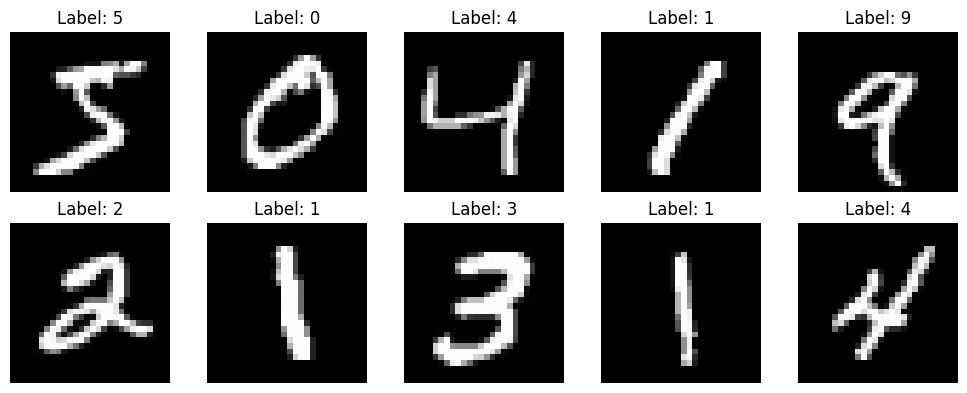

In [121]:
# Visualizing the dataset
import matplotlib.pyplot as plt

def show_images(images, labels, ncols=5):
    nrows = (len(images) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))
    axes = axes.flatten()

    for i, (image, label) in enumerate(zip(images, labels)):
        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title('Label: {}'.format(label))

    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

show_images(x_train[:10], y_train[:10])

### Data Pre-Processing

#### Feature Selection

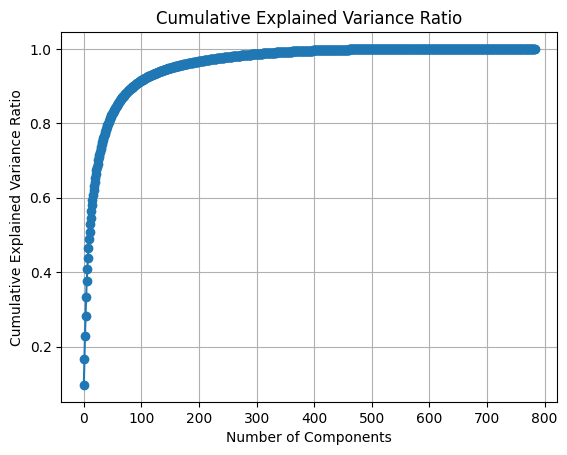

Number of components to retain: 154


In [122]:
# Usin PCA to find out the most relevant number of pixels after flattening the image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def select_n_components_variance_ratio(images, target_variance=0.95):
    # Flatten the images
    flattened_images = images.reshape(images.shape[0], -1)
    # Apply PCA
    pca = PCA()
    pca.fit(flattened_images)
    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # Find the number of components to retain
    n_components = np.argmax(cumulative_variance_ratio >= target_variance) + 1
    # Plot cumulative explained variance ratio
    plt.figure()
    plt.plot(cumulative_variance_ratio, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.show()
    return n_components

n_components = select_n_components_variance_ratio(x_train)
print("Number of components to retain:", n_components)

So, 154 pixels are enough to help us make out the datapoints instead of 728 points

In [123]:
# We use Maxpooling with kernel=(2,2), which surprisingly give pixels in the range calculated by PCA
import numpy as np
import tensorflow as tf

x_train = np.expand_dims(x_train, axis=-1)
print("Shape before max pooling:", x_train.shape)

max_pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')

x_train = max_pooling_layer(x_train)
print("Shape after max pooling:", x_train_maxpooled.shape)

Shape before max pooling: (60000, 28, 28, 1)
Shape after max pooling: (60000, 14, 14, 1)


### Quantum Embedding

2. Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations

- we have 196 pixels total in each image
- Amplitude encoding can store 2**n features worth of data in just n qubits
- Therefore, we use 8 qubits that can take a feature or image containing 256 pixels
- We only have 196 pixels in our images, so rest of the cells are padded with 0
- we use additional weights for training purposes later on

In [124]:
import pennylane as qml
import tensorflow as tf

dev = qml.device('default.qubit', wires=8)

@qml.qnode(dev)
def circuit(features=None, weights=None):
    # Encoding the features using AmplitudeEmbedding
    qml.templates.AmplitudeEmbedding(features, wires=range(8), normalize=True, pad_with=0.)

    # Apply trainable parametrized gates
    for i in range(len(weights)):
        qml.Rot(*weights[i], wires=i)

    return qml.expval(qml.Z(0)),qml.state()

In [125]:
import numpy as np

# Define the number of trainable parameters
num_params = 8
sample_weights = np.random.randn(num_params, 3)  # 3 parameters (angles) per gate

print("Sample weights:\n", sample_weights)

x_train = tf.reshape(x_train, (x_train.shape[0], -1))
res, state1 = circuit(features=x_train[0],weights=sample_weights)
res, state2 = circuit(features=x_train[1],weights=sample_weights)

print(qml.draw(circuit)(x_train[0],sample_weights))

Sample weights:
 [[ 0.88546051  0.94673594 -0.58952507]
 [ 0.89328559 -0.47995457 -0.9565565 ]
 [ 0.74530655  0.12264249  0.1894947 ]
 [ 0.49744272  1.53961324 -0.30899406]
 [-0.65946217 -0.2793687   0.30057685]
 [ 0.26195717  0.00680437 -0.2026968 ]
 [ 2.29829623 -1.19643364  0.17959025]
 [-0.42256113 -1.62226269 -0.27570746]]
0: ─╭|Ψ⟩──Rot(0.89,0.95,-0.59)───┤  <Z>  State
1: ─├|Ψ⟩──Rot(0.89,-0.48,-0.96)──┤       State
2: ─├|Ψ⟩──Rot(0.75,0.12,0.19)────┤       State
3: ─├|Ψ⟩──Rot(0.50,1.54,-0.31)───┤       State
4: ─├|Ψ⟩──Rot(-0.66,-0.28,0.30)──┤       State
5: ─├|Ψ⟩──Rot(0.26,0.01,-0.20)───┤       State
6: ─├|Ψ⟩──Rot(2.30,-1.20,0.18)───┤       State
7: ─╰|Ψ⟩──Rot(-0.42,-1.62,-0.28)─┤       State


### Swap Test

3. Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.

We are doing this test to compare similarity bwtween 2 quantum states

In [126]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AmplitudeEmbedding

inp1 = state1
inp2 = state2

qubit_number = 8
dev = qml.device('default.qubit', wires=3 * qubit_number)

@qml.qnode(dev)
def prepare_reg1(inp1, inp2):
    inp = np.concatenate([inp1, inp2])
    AmplitudeEmbedding(features=inp, wires=range(qubit_number, 3 * qubit_number), normalize=True, pad_with=0.)

    ancillea = []
    for i in range(qubit_number):

        anc = i
        ancillea.append(anc)
        first_state = i+qubit_number
        second_state = i+ 2*qubit_number
        qml.CSWAP(wires=[anc, first_state, second_state])

    return qml.expval(qml.operation.Tensor(*[qml.PauliZ(i) for i in ancillea]))


x= prepare_reg1(inp1,inp1)
print(qml.draw(prepare_reg1)(inp1,inp1))

 0: ──────╭●──────────────────────────────────────────────┤ ╭<Z@Z@Z@Z@Z@Z@Z@Z>
 1: ──────│─────╭●────────────────────────────────────────┤ ├<Z@Z@Z@Z@Z@Z@Z@Z>
 2: ──────│─────│─────╭●──────────────────────────────────┤ ├<Z@Z@Z@Z@Z@Z@Z@Z>
 3: ──────│─────│─────│─────╭●────────────────────────────┤ ├<Z@Z@Z@Z@Z@Z@Z@Z>
 4: ──────│─────│─────│─────│─────╭●──────────────────────┤ ├<Z@Z@Z@Z@Z@Z@Z@Z>
 5: ──────│─────│─────│─────│─────│─────╭●────────────────┤ ├<Z@Z@Z@Z@Z@Z@Z@Z>
 6: ──────│─────│─────│─────│─────│─────│─────╭●──────────┤ ├<Z@Z@Z@Z@Z@Z@Z@Z>
 7: ──────│─────│─────│─────│─────│─────│─────│─────╭●────┤ ╰<Z@Z@Z@Z@Z@Z@Z@Z>
 8: ─╭|Ψ⟩─├SWAP─│─────│─────│─────│─────│─────│─────│─────┤                   
 9: ─├|Ψ⟩─│─────├SWAP─│─────│─────│─────│─────│─────│─────┤                   
10: ─├|Ψ⟩─│─────│─────├SWAP─│─────│─────│─────│─────│─────┤                   
11: ─├|Ψ⟩─│─────│─────│─────├SWAP─│─────│─────│─────│─────┤                   
12: ─├|Ψ⟩─│─────│─────│─────│─────├SWAP─│─────│─────

In [127]:
qml.math.fidelity_statevector(state1, state1) # same state, higher fidelity

<tf.Tensor: shape=(), dtype=float64, numpy=0.9999998222840497>

In [128]:
qml.math.fidelity_statevector(state1, state2) # different state, lower fidelity

<tf.Tensor: shape=(), dtype=float64, numpy=0.3482434507669067>

### Defining Model Parameters and Pairs of Images

4. Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.

In [129]:
import pennylane as qml
import tensorflow as tf
import numpy as np

dev = qml.device('default.qubit', wires=8)

@qml.qnode(dev)
def circuit(features=None, weights=None):
    # Encoding the features using AmplitudeEmbedding
    qml.templates.AmplitudeEmbedding(features, wires=range(8), normalize=True, pad_with=0.)
    # Apply trainable parametrized gates
    for i in range(len(weights)):
        qml.Rot(*weights[i], wires=i)
    return qml.expval(qml.Z(0)),qml.state()

def quantum_embedding_model(features, weights):
    res, state = circuit(features=features, weights=weights)
    return state

# Define a function to calculate fidelity between two quantum states
def quantum_fidelity(state1, state2):
    return qml.math.fidelity_statevector(state1, state2)

# Define the contrastive loss function
def contrastive_loss(y_true, similarity, margin=1):
    # Compute loss for similar pairs (y_true == 1)
    loss_similar = y_true * tf.square(similarity)
    # Compute loss for dissimilar pairs (y_true == 0)
    loss_dissimilar = (1 - y_true) * tf.square(tf.maximum(margin - similarity, 0))
    # Combine losses
    loss = 0.5 * (loss_similar + loss_dissimilar)
    return tf.reduce_mean(loss)


# Generate sample weights
num_params = 8  # Number of parameters
sample_weights = np.random.randn(num_params, 3)  # Random weights

# Load MNIST data, just a few datapoints for simplicity
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
(x_train, y_train) = (x_train[:5], y_train[:5])
x_train = x_train / 255.0

x_train = np.expand_dims(x_train, axis=-1)
# Define the max pooling layer
max_pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
# Apply max pooling to the input images
x_train = max_pooling_layer(x_train)
x_train = np.squeeze(x_train, axis=-1)

# Generate pairs of images for training
pairs = []
labels = []
for i in range(len(x_train)):
    for j in range(i+1, len(x_train)):
        pairs.append((x_train[i], x_train[j]))
        labels.append(1 if y_train[i] == y_train[j] else 0)

pairs = np.array(pairs)
labels = np.array(labels)

# Shuffle the data
perm = np.random.permutation(len(pairs))
pairs = pairs[perm]
labels = labels[perm]

# Define training parameters
num_epochs = 10
batch_size = 2
learning_rate = 0.001

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

sample_weights_tf = tf.convert_to_tensor(sample_weights, dtype=tf.float32)

### Training with anchor image, positive image and negative image

In [133]:
import numpy as np
import tensorflow as tf

num_epochs = 10
batch_size = 2
learning_rate = 0.001
margin = 1
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = len(x_train) // batch_size

    for batch_idx in range(num_batches):
        # Generate pairs of images and labels
        positive_pairs = []
        negative_pairs = []
        labels = []
        for i in range(batch_size):
            # Select a random image from the batch
            anchor_image = x_train[np.random.randint(0, len(x_train))]

            # Select a positive pair (similar image)
            positive_image = anchor_image

            # Select a negative pair (dissimilar image)
            negative_image = x_train[np.random.randint(0, len(x_train))]
            while np.array_equal(negative_image, anchor_image):
                negative_image = x_train[np.random.randint(0, len(x_train))]

            positive_pairs.append((anchor_image, positive_image))
            negative_pairs.append((anchor_image, negative_image))
            labels.append(1)  # Similar pair
            labels.append(0)  # Dissimilar pair

        # Compute embeddings and similarity scores for positive pairs
        positive_similarities = []
        for pair in positive_pairs:
            pair0= tf.reshape(pair[0], -1)
            pair1 = tf.reshape(pair[1], -1)
            anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
            positive_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
            similarity = quantum_fidelity(anchor_embedding, positive_embedding)
            positive_similarities.append(similarity)

        # Compute embeddings and similarity scores for negative pairs
        negative_similarities = []
        for pair in negative_pairs:
            pair0= tf.reshape(pair[0], -1)
            pair1 = tf.reshape(pair[1], -1)
            anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
            negative_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
            similarity = quantum_fidelity(anchor_embedding, negative_embedding)
            negative_similarities.append(similarity)

        # Concatenate positive and negative similarities
        print("positive_similarity: ")
        print(positive_similarities)

        print("negative_similarity: ")
        print(negative_similarities)
        all_similarities = positive_similarities + negative_similarities

        # Convert to TensorFlow tensor
        all_similarities_tf = tf.convert_to_tensor(all_similarities, dtype=tf.float32)
        labels_tf = tf.convert_to_tensor(labels, dtype=tf.float32)

        # Compute contrastive loss
        with tf.GradientTape() as tape:
            loss = contrastive_loss(labels_tf, all_similarities_tf, margin=margin)


        # Calculate gradients
        gradients = tape.gradient(loss, sample_weights_tf)

        # Update weights
        # optimizer.apply_gradients(zip([gradients], [sample_weights_tf]))

        total_loss += loss.numpy()

    print("Epoch {}, Loss: {:.4f}".format(epoch + 1, total_loss / num_batches))


positive_similarity: 
[<tf.Tensor: shape=(), dtype=float64, numpy=0.9999997140348835>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9999997120254801>]
negative_similarity: 
[<tf.Tensor: shape=(), dtype=float64, numpy=0.2106419498156035>, <tf.Tensor: shape=(), dtype=float64, numpy=0.1533962178698945>]
positive_similarity: 
[<tf.Tensor: shape=(), dtype=float64, numpy=0.9999997531376396>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9999997140348835>]
negative_similarity: 
[<tf.Tensor: shape=(), dtype=float64, numpy=0.10654151276630112>, <tf.Tensor: shape=(), dtype=float64, numpy=0.087229201481301>]
Epoch 1, Loss: 0.2254
positive_similarity: 
[<tf.Tensor: shape=(), dtype=float64, numpy=0.9999997140348835>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9999997531376396>]
negative_similarity: 
[<tf.Tensor: shape=(), dtype=float64, numpy=0.087229201481301>, <tf.Tensor: shape=(), dtype=float64, numpy=0.12483768896003787>]
positive_similarity: 
[<tf.Tensor: shape=(), dtype=float64, numpy=0.9999

### Evaluation

Similarity score: tf.Tensor(0.9999998895010674, shape=(), dtype=float64) Label: 1


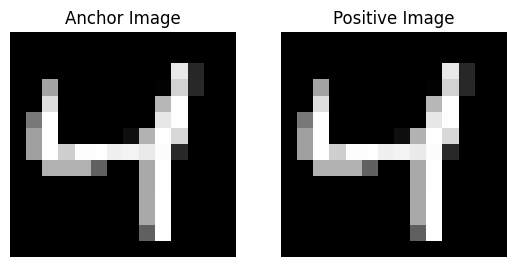

Similarity score: tf.Tensor(0.087229201481301, shape=(), dtype=float64) Label: 0


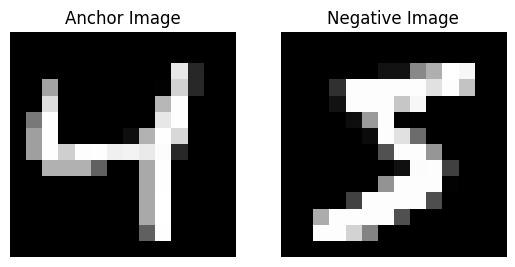

In [134]:
def evaluate_model(model, x_eval, num_pairs=2):
    positive_pairs = []
    negative_pairs = []

    # Generate pairs of images
    anchor_image = x_train[np.random.randint(0, len(x_train))]

    # Select a positive pair (similar image)
    positive_image = anchor_image

    # Select a negative pair (dissimilar image)
    negative_image = x_train[np.random.randint(0, len(x_train))]
    while np.array_equal(negative_image, anchor_image):
      negative_image = x_train[np.random.randint(0, len(x_train))]

    positive_pairs.append((anchor_image, positive_image))
    negative_pairs.append((anchor_image, negative_image))
    labels.append(1)  # Similar pair
    labels.append(0)  # Dissimilar pair


    for pair in positive_pairs:
      pair0= tf.reshape(pair[0], -1)
      pair1 = tf.reshape(pair[1], -1)
      anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
      positive_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
      similarity = quantum_fidelity(anchor_embedding, positive_embedding)
      print("Similarity score:", similarity, "Label: 1")
      plt.figure()
      plt.subplot(1, 2, 1)
      plt.imshow(pair[0], cmap='gray')
      plt.title("Anchor Image")
      plt.axis('off')
      plt.subplot(1, 2, 2)
      plt.imshow(pair[1], cmap='gray')
      plt.title("Positive Image")
      plt.axis('off')
      plt.show()

    # Compute embeddings and similarity scores for negative pairs
    for pair in negative_pairs:
        pair0= tf.reshape(pair[0], -1)
        pair1 = tf.reshape(pair[1], -1)
        anchor_embedding = quantum_embedding_model(features=pair0, weights=sample_weights_tf)
        negative_embedding = quantum_embedding_model(features=pair1, weights=sample_weights_tf)
        similarity = quantum_fidelity(anchor_embedding, negative_embedding)
        print("Similarity score:", similarity, "Label: 0")
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(pair[0], cmap='gray')
        plt.title("Anchor Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(pair[1], cmap='gray')
        plt.title("Negative Image")
        plt.axis('off')
        plt.show()

evaluate_model(quantum_embedding_model, x_train)